# Generative Adversarial Network with TensorFlow 

In [3]:
# for model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, datasets, Sequential
import math

# for GIFs
import glob
import imageio
import os
import sys
import PIL
import time

from IPython import display

## Hyperparameters

Buffer size is primarily used for random sampling using `tf.data.Dataset.shuffle`. Unused for now, Since i will set a seed to make debugging and optimizing easier

In [4]:
BUFFER_SIZE = 60000
tf.random.set_seed(420)

In [5]:
BATCH_SIZE = 128
NOISE_DIM = 100
IMGS_TO_GEN = 4
EPOCHS = 10

In [6]:
FEATURE_MAP_SIZE = 7
CHANNELS = 256
SPATIAL_TENSOR = (FEATURE_MAP_SIZE, FEATURE_MAP_SIZE, CHANNELS)
FILTERS = (CHANNELS, 64, 1)

## Data

Load the data from keras.

In [7]:
(train_imgs, train_lbls), (test_imgs, test_lbls) = datasets.mnist.load_data()

Reshape img tensor into *(n_instances, px width, px height, channels)*. Channels are the number of color channels in the image. this could be 1 for grayscale or 3 for RGB

Since our images are grayscale, set channels to 1 and transform them to float32, since we normalize the data to fall between 0 and 1.

In [8]:
train_imgs = train_imgs.reshape(train_imgs.shape[0], 28, 28, 1)
train_imgs = train_imgs.astype("float32") / 255.0

Create a tf dataset and make batches.  Smaller batches hinder training potential, but are less memory intensive.

From TensorFlow docs:
* for perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required
* reshuffle_each_iteration controls whether the shuffle order should be different for each epoch (try without)
* To shuffle an entire dataset, set buffer_size=dataset.cardinality(). This is equivalent to setting the buffer_size equal to the number of elements in the dataset, resulting in uniform shuffle.

In [9]:
train_df = tf.data.Dataset.from_tensor_slices(train_imgs)
# train_df = train_df.batch(BATCH_SIZE).shuffle(BUFFER_SIZE)

2025-03-13 16:37:07.478833: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-03-13 16:37:07.483417: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


## Models

### Generator

Start with a `Dense` layer that takes an input of 100 random values (noise) and transforms it into a vector of size 7×7×256=12544.

`BatchNormalization` helps stabilize training by normalizing the activations of the layer before it.

For hidden layers, `LeakyReLU` is better than `ReLU`, since it avoids "dying ReLU" problem and provides better gradient flow. Output layer should have `tanh` activation function, since it our values are normalized to be between -1 and 1, while `sigmoid` outputs values between 0 and 1.

`Reshape` transforms 49-element vector into a 7x7x1 tensor, that can be interpreted as a 7px×7px image with 1 channel (one feature map). It converts the vector representation into a spatial representation that can then be processed by convolutional layers.

Core of our GAN network: `Conv2DTranspose` does upsampling (it increases the spatial dimensions).  It inserts values into the input and performs a convolution. It adds padding and then applies a standard convolution operation to this expanded output. The kernel weigths are learned during training.

In [10]:
def build_generator():
    model = Sequential()
    model.add(layers.Input(shape=(100,)))

    model.add(layers.Dense(math.prod(SPATIAL_TENSOR), use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape(SPATIAL_TENSOR))

    model.add(layers.Conv2DTranspose(FILTERS[0], (5, 5), strides=(1, 1), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(FILTERS[1], (5, 5), strides=(2, 2), padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(FILTERS[2], (5, 5), strides=(2, 2), padding="same", activation="tanh", use_bias=False))

    return model

In [11]:
generator = build_generator()
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 256)      │     1,638,400 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       409,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,355,456 (12.80 MB)

 Trainable params: 3,329,728 (12.70 MB)

 Non-trainable params: 25,728 (100.50 KB)

### Discriminator

The discriminator is a convolutional neural network that takes an image as input and outputs a single value, representing the probability that the input is real. In other words, it is a classifier.

Input shape is the same as the output shape of the generator. It is 28px×28px image with 1 channel. 

Every convolution we dropout a third of the neurons to prevent overfitting. 

Lastly, we flatten the remaining neurons into a 1D array that we can pass to the `Dense` output layer with a single output.

In [ ]:
def build_discriminator():
    model = Sequential()
    model.add(layers.Input(shape=(28, 28, CHANNELS)))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [22]:
discriminator = build_discriminator()
discriminator.summary()

/home/pogacha/progAAAAAAA/GAN-osuprProject/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

## Training

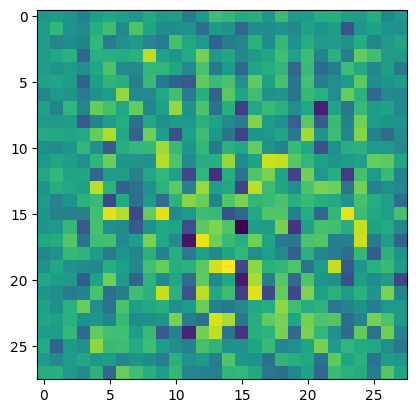

tf.Tensor([[-0.00098301]], shape=(1, 1), dtype=float32)


In [14]:
# make an image
noise = tf.random.normal([1, 100])
gen_img = generator(noise, training=False)
plt.imshow(gen_img[0, :, :, 0])
plt.show()

# classify an image
decision = discriminator(gen_img)
print(decision)
